In [1]:
from keras import backend as K
from keras.models import Model
from keras.layers.convolutional import Conv1D
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.utils import np_utils
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
#load training data
train = json.load(open('../data/train.json'))

In [52]:
#load test data
test = json.load(open('../data/test.json'))

# Preprocess

In [50]:
def normalize(X1):
    '''normalizes to 0 to 1 scale'''
    norm = ((X1-X1.min())/(X1.max()-X1.min()))
    return norm

def preprocess(data):
    '''
    preprocesses the data and returns two list of processed data, 
    one normalized on 0 to 1 scale, dual channel picture, 75x75x2
    one normalized to power ratio, and combined, single channel picture, 75x75x1
    '''
    #make empty list for dataset normalized from 0 to 1
    X_data_scale = list()

    #make empty list for dataset normalized by power ratio
    X_data_power = list()

    #itterate over each element of the data
    for i in range(len(data)):
        #get elements of entry
        id = (data[i]['id'])
        B1 = np.reshape(data[i]['band_1'], (75,75))
        B2 = np.reshape(data[i]['band_2'], (75,75))
        
        #normalize to 0 to 1 range
        B1_norm = normalize(B1)
        B2_norm = normalize(B2)
        norm_merge = np.dstack((B1_norm,B2_norm))
        
        #transform to power
        B1_power = np.power(10, np.divide(B1, 20))
        B2_power = np.power(10, np.divide(B2, 20))
        power_merge = normalize(np.multiply(10,np.log10(np.add(np.power(10,np.divide(B1_power,10)),np.power(10,np.divide(B2_power,10))))))

        #df.append({'id':id, 'image':norm_merge})
        #dp.append({'id':id, 'image':power_merge})
        X_data_scale.append(norm_merge)
        X_data_power.append(power_merge)
        
    return np.array(X_data_scale), np.array(X_data_power)

def get_classification(data):
    '''retrieves classification for each image in testing dataset'''
    y_data = list()
    for i in range(len(data)):
        #id = (data[i]['id'])
        classification = (data[i]['is_iceberg'])
        #target.append({'id':id, 'is_iceberg':classification})
        y_data.append([classification])
    return(np.array(y_data))

def get_id(data):
    '''retrieves classification for each image in testing dataset'''
    id = list()
    for i in range(len(data)):
        sample = (data[i]['id'])
        id.append([sample])
    return(np.array(id))

def get_angle(data):
    '''retrieves classification for each image in testing dataset'''
    angle = list()
    for i in range(len(data)):
        sample = (data[i]['inc_angle'])
        angle.append(sample)
    return(angle)

In [51]:
#preprocess training dataset
X_train_scale, X_train_power = preprocess(train)
y_train = get_classification(train)
train_id = get_id(train)

In [53]:
#preprocess testing dataset
X_test_scale, X_test_power = preprocess(test)
test_id = get_id(test)

# Visualize Sample Plot

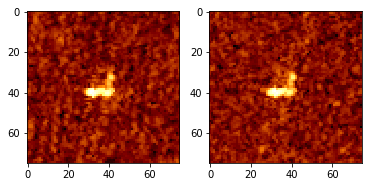

In [54]:
fig = plt.figure()
plt.subplot(121)
B1_norm = normalize(np.reshape(train[1]['band_1'], (75,75)))
plt.imshow(B1_norm, cmap='afmhot')
plt.subplot(122)
B2_norm = normalize(np.reshape(train[1]['band_2'], (75,75)))
plt.imshow(B2_norm, cmap='afmhot')
plt.show()

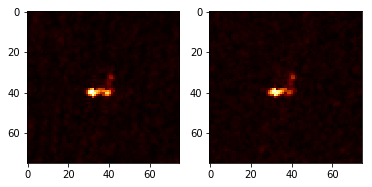

In [55]:
fig = plt.figure()
plt.subplot(121)
B1_power = np.power(10, np.divide(np.reshape(train[1]['band_1'], (75,75)), 20))
plt.imshow(B1_power, cmap='afmhot')
plt.subplot(122)
B2_power = np.power(10, np.divide(np.reshape(train[1]['band_2'], (75,75)), 20))
plt.imshow(B2_power, cmap='afmhot')
plt.show()

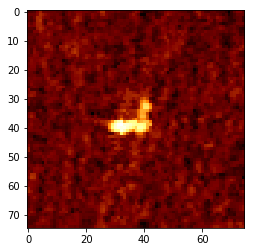

In [56]:
dd=(np.multiply(10,np.log10(np.add(np.power(10,np.divide(B1_norm,10)),np.power(10,np.divide(B2_norm,10))))))
plt.imshow(dd, cmap='afmhot')

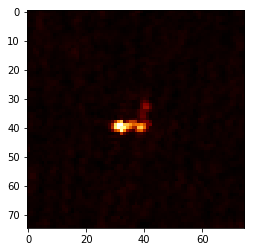

In [57]:
dm=(np.multiply(10,np.log10(np.add(np.power(10,np.divide(B1_power,10)),np.power(10,np.divide(B2_power,10))))))
plt.imshow(dm, cmap='afmhot')

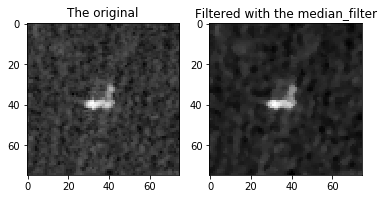

In [58]:
from scipy.ndimage.filters import median_filter
from matplotlib.pylab import imread, imshow, subplot, title, show, get_cmap

img = dd
new = median_filter(img, 3)

subplot(121); imshow(img, cmap=get_cmap('gray'));
title('The original')
subplot(122); imshow(new, cmap=get_cmap('gray'));
title('Filtered with the median_filter')

show()

# Split Test & Training Data

In [59]:
#split training & testing set
from sklearn.model_selection import train_test_split
X_train_d_scale, X_test_d_scale, y_train_d_scale, y_test_d_scale = train_test_split(X_train_scale, y_train, test_size=0.2, random_state=0)

In [60]:
#hyperparameters
batch_size = 32 #number of training examples to consider at once
num_epochs = 200 #itterate n times over training set
kernel_size = 3 #3x3 kernal
pool_size = 2 #2x2 pooling
conv_depth_1 = 32 # first layer 32 kernals
conv_depth_2 = 64 # second layer 64 kernals
drop_prob_1 = 0.2 # probability of dropout after pooling
drop_prob_2 = 0.65 # probability of dropout in fully-connected layer
hidden_size = 512 #number of neurons in fully-connected layer

In [61]:
num_train, height, width, depth = X_train_scale.shape  #1604 training samples
num_test = X_test_scale.shape[0] #8424 testing samples
num_classes = np.unique(y_train).shape[0] #number of unique classes (iceberg: yes(1), no(0))

In [62]:
#one hot encoding labels
Y_train = np_utils.to_categorical(y_train_d_scale, num_classes)
Y_test = np_utils.to_categorical(y_test_d_scale, num_classes)

# ConvNet Training

In [63]:
inp = Input(shape=(height, width, depth)) 

# Conv [32] -> Conv [32] -> Pool (with dropout on the pooling layer)
conv_1 = Convolution2D(conv_depth_1, (kernel_size, kernel_size), padding='same', activation='relu')(inp)
conv_2 = Convolution2D(conv_depth_1, (kernel_size, kernel_size), padding='same', activation='relu')(conv_1)
pool_1 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_2)
drop_1 = Dropout(drop_prob_1)(pool_1)
# Conv [64] -> Conv [64] -> Pool (with dropout on the pooling layer)
conv_3 = Convolution2D(conv_depth_2, (kernel_size, kernel_size), padding='same', activation='relu')(drop_1)
conv_4 = Convolution2D(conv_depth_2, (kernel_size, kernel_size), padding='same', activation='relu')(conv_3)
pool_2 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_4)
drop_2 = Dropout(drop_prob_1)(pool_2)
# Now flatten to 1D, apply FC -> ReLU (with dropout) -> softmax
flat = Flatten()(drop_2)
hidden = Dense(hidden_size, activation='relu')(flat)
drop_3 = Dropout(drop_prob_2)(hidden)
out = Dense(num_classes, activation='softmax')(drop_3)

model = Model(inputs=inp, outputs=out) # To define a model, just specify its input and output layers

model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer='adam', # using the Adam optimiser
              metrics=['accuracy']) # reporting the accuracy

history = model.fit(X_train_d_scale, Y_train,                # Train the model using the training set...
          batch_size=batch_size, epochs=num_epochs,
          verbose=1, validation_split=0.1) # ...holding out 10% of the data for validation
model.evaluate(X_test_d_scale, Y_test, verbose=1)  # Evaluate the trained model on the test set!

Train on 1154 samples, validate on 129 samples
Epoch 1/200
1154/1154 [==============================] - 63s 54ms/step - loss: 0.7373 - acc: 0.5659 - val_loss: 0.7257 - val_acc: 0.4419
Epoch 2/200
1154/1154 [==============================] - 49s 43ms/step - loss: 0.6792 - acc: 0.5815 - val_loss: 0.6203 - val_acc: 0.6124
Epoch 3/200
1154/1154 [==============================] - 47s 40ms/step - loss: 0.6194 - acc: 0.6646 - val_loss: 0.6678 - val_acc: 0.5504
Epoch 4/200
1154/1154 [==============================] - 47s 41ms/step - loss: 0.6081 - acc: 0.6516 - val_loss: 0.6340 - val_acc: 0.6357
Epoch 5/200
1154/1154 [==============================] - 46s 40ms/step - loss: 0.5973 - acc: 0.6837 - val_loss: 0.5603 - val_acc: 0.6744
Epoch 6/200
1154/1154 [==============================] - 45s 39ms/step - loss: 0.5889 - acc: 0.6603 - val_loss: 0.5493 - val_acc: 0.6744
Epoch 7/200
1154/1154 [==============================] - 46s 40ms/step - loss: 0.5808 - acc: 0.6768 - val_loss: 0.5522 - val_acc: 0

1154/1154 [==============================] - 45s 39ms/step - loss: 0.0155 - acc: 0.9965 - val_loss: 0.5669 - val_acc: 0.8217
Epoch 61/200
1154/1154 [==============================] - 45s 39ms/step - loss: 0.0305 - acc: 0.9887 - val_loss: 0.6395 - val_acc: 0.8605
Epoch 62/200
1154/1154 [==============================] - 45s 39ms/step - loss: 0.0158 - acc: 0.9965 - val_loss: 0.6364 - val_acc: 0.8450
Epoch 63/200
1154/1154 [==============================] - 45s 39ms/step - loss: 0.0207 - acc: 0.9922 - val_loss: 0.7252 - val_acc: 0.8295
Epoch 64/200
1154/1154 [==============================] - 45s 39ms/step - loss: 0.0546 - acc: 0.9861 - val_loss: 0.4586 - val_acc: 0.8605
Epoch 65/200
1154/1154 [==============================] - 51s 44ms/step - loss: 0.0132 - acc: 0.9974 - val_loss: 0.6110 - val_acc: 0.8527
Epoch 66/200
1154/1154 [==============================] - 45s 39ms/step - loss: 0.0079 - acc: 0.9965 - val_loss: 0.5025 - val_acc: 0.8527
Epoch 67/200
1154/1154 [=======================

Epoch 178/200
1154/1154 [==============================] - 42s 36ms/step - loss: 0.0065 - acc: 0.9983 - val_loss: 0.7104 - val_acc: 0.8450
Epoch 179/200
1154/1154 [==============================] - 42s 36ms/step - loss: 0.0014 - acc: 0.9991 - val_loss: 0.9058 - val_acc: 0.8295
Epoch 180/200
1154/1154 [==============================] - 42s 36ms/step - loss: 0.0023 - acc: 0.9991 - val_loss: 0.7958 - val_acc: 0.8372
Epoch 181/200
1154/1154 [==============================] - 42s 37ms/step - loss: 0.0041 - acc: 0.9983 - val_loss: 0.7425 - val_acc: 0.8682
Epoch 182/200
1154/1154 [==============================] - 43s 37ms/step - loss: 9.6554e-04 - acc: 1.0000 - val_loss: 0.9333 - val_acc: 0.8372
Epoch 183/200
1154/1154 [==============================] - 42s 37ms/step - loss: 0.0069 - acc: 0.9974 - val_loss: 0.8873 - val_acc: 0.8760
Epoch 184/200
1154/1154 [==============================] - 42s 37ms/step - loss: 0.0097 - acc: 0.9965 - val_loss: 0.9696 - val_acc: 0.8450
Epoch 185/200
1154/1154

[0.95284269665399812, 0.84423676012461057]

## Persist the learned model to local

In [70]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [74]:
import pickle
with open('trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [71]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75, 75, 2)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        608       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 37, 64)        36928     
__________

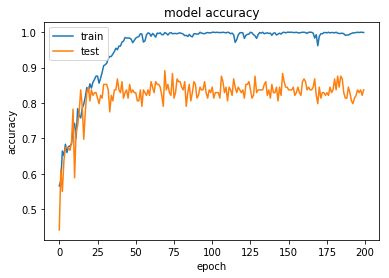

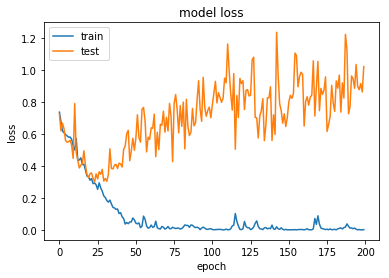

In [72]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [75]:
from keras.models import model_from_json
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


### Predictions made from local file

In [76]:
dd=loaded_model.predict(X_test_scale,batch_size=batch_size,verbose=1)
results = pd.DataFrame()

for i in range(len(test_id)):
    results = results.append({'id': test_id[i][0], 'is_iceberg' :dd[i][1]}, ignore_index=True)

results.to_csv("loadedmodelresults.csv",index=False)

8424/8424 [==============================] - 121s 14ms/step


### Prediction made directly from model

In [77]:
dd2=model.predict(X_test_scale,batch_size=batch_size,verbose=1)
direct_model_results = pd.DataFrame()

for i in range(len(test_id)):
    direct_model_results = direct_model_results.append({'id': test_id[i][0], 'is_iceberg' :dd2[i][1]}, ignore_index=True)

direct_model_results.to_csv("directmodelresults.csv",index=False)

8424/8424 [==============================] - 144s 17ms/step
